In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import numpy as np
from pyscf import dft

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
#Sampled points can be biased in favor of smaller values of s
# Define the enhancement factor functions (Fx and Fc)
def Fx(rho, grad_rho):
    rho = jnp.maximum(1e-12, rho) #Prevents division by 0
    k_F = (3 * jnp.pi**2 * rho)**(1/3)
    s = grad_rho / (2 * k_F * rho)
    kappa, mu = 0.804, 0.21951

    Fx = 1 + kappa - kappa / (1 + mu * s**2 / kappa) #exchange enhancement factor

    return Fx

def Fc(rho, grad_rho): #Assumes zeta = 0
    rho = jnp.maximum(1e-12, rho) #Prevents division by 0
    pi = jnp.pi
    k_F = (3 * pi**2 * rho)**(1/3)
    s = grad_rho / (2 * k_F * rho)
    k_s = jnp.sqrt((4 * k_F) / pi)
    t = jnp.abs(grad_rho) / (2 * k_s * rho)
    beta = 0.066725
    gamma = (1 - jnp.log(2)) / (pi**2)

    #Calculate e_heg_c (heterogeneous electron gas correlation energy)
    N = rho.size 
    rho_array = np.zeros((6, N))  # Initialize the rho_array with the correct shape. Only the first element (rho) matters, so the rest are populated with 0. 
    rho_array[0, :] = rho  # Populate first array value with rho
    e_heg_c = dft.libxc.eval_xc('LDA_C_PW,', rho_array, spin=0, deriv=1)[0]

    A = (beta / gamma) / (jnp.exp(-e_heg_c / (gamma)) - 1)

    H = gamma * jnp.log(1 + (beta / gamma) * t**2 * ((1 + A * t**2) / (1 + A * t**2 + A**2 * t**4)))

    Fc = 1 + (H / e_heg_c) #correlation enhancement factor

    return Fc

# Define the neural network module for Fx
class FxNet(eqx.Module):
    depth: int
    nodes: int
    seed: int
    net: eqx.nn.MLP

    def __init__(self, depth: int, nodes: int, seed: int):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.net = eqx.nn.MLP(in_size = 2, # Input is rho, grad_rho
                              out_size = 1, # Output is Fx
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))

    def __call__(self, inputs):
        return self.net(inputs).squeeze()

# Define the neural network module for Fc
class FcNet(eqx.Module):
    depth: int
    nodes: int
    seed: int
    net: eqx.nn.MLP = eqx.field(init=False)

    def __init__(self, depth: int, nodes: int, seed: int):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.net = eqx.nn.MLP(in_size=2, # Input is rho, grad_rho
                              out_size=1,  # Output is Fc
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(seed))

    def __call__(self, inputs):
        return self.net(inputs).squeeze()


In [9]:
# Constants for generating grid points
START_RHO = 1e-8
STOP_RHO = 5.0
START_S = 0.0
STOP_S = 5.0
NPTS = 30000  # Note: Number of grid points [i.e. (x,y) pairs] is actually sqrt(NPTS).

# Generate training data
# Create more points for small values of s
s_values_low = jnp.linspace(START_S, 0.5, num=int(0.7 * jnp.sqrt(NPTS)))
s_values_high = jnp.linspace(0.5, STOP_S, num=int(0.3 * jnp.sqrt(NPTS)))
s_values = jnp.concatenate([s_values_low, s_values_high])

rho_values = jnp.logspace(jnp.log10(START_RHO), jnp.log10(STOP_RHO), num=int(jnp.sqrt(NPTS)))
#s_values = jnp.linspace(START_S, STOP_S, num=int(jnp.sqrt(NPTS))) #Use this for unbiased sampling

rho_mesh, s_mesh = jnp.meshgrid(rho_values, s_values)
rho_flat = rho_mesh.flatten()
s_flat = s_mesh.flatten()

# Calculate grad_rho
k_F = (3 * jnp.pi**2 * rho_flat)**(1/3)
grad_rho_flat = 2 * s_flat * k_F * rho_flat

# Create input array
inputs = jnp.stack([rho_flat, grad_rho_flat], axis=1)

# Calculate true Fx and Fc values
true_fx = Fx(rho_flat, grad_rho_flat)
true_fc = Fc(rho_flat, grad_rho_flat)

# Normalize inputs and outputs
inputs_mean = inputs.mean(axis=0)
inputs_std = inputs.std(axis=0)
inputs_normalized = (inputs - inputs_mean) / (inputs_std + 1e-8)

true_fx_mean = true_fx.mean()
true_fx_std = true_fx.std()
true_fx_normalized = (true_fx - true_fx_mean) / (true_fx_std + 1e-8)

true_fc_mean = true_fc.mean()
true_fc_std = true_fc.std()
true_fc_normalized = (true_fc - true_fc_mean) / (true_fc_std + 1e-8)

# Define the training loop function
def loop(model, model_name, inputs, ref, optimizer, epochs=1000000, printevery=2500): #model_name is just for printing purposes
    @eqx.filter_value_and_grad
    def compute_loss(model, inputs, ref):
        pred = jax.vmap(model)(inputs)
        loss = jnp.mean(jnp.abs(pred - ref))
        return loss

    @eqx.filter_jit
    def make_step(model, inputs, ref, opt_state):
        loss, grad = compute_loss(model, inputs, ref)
        updates, opt_state = optimizer.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
    print(f"Starting training for model: {model_name}")
    
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    losses = []

    for step in range(epochs):
        loss, model, opt_state = make_step(model, inputs, ref, opt_state)
        loss = loss.item()
        losses.append(loss)
        if step % printevery == 0:
            print(f'Epoch {step}: Loss = {loss}')

    return model, losses

# Create optimizers
optimizer_fx = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=1e-4)
)
optimizer_fc = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=1e-4)
)

# Initialize the models
# model_fx = FxNet(depth=4, nodes=64, seed=42)
# model_fc = FcNet(depth=4, nodes=64, seed=42)
#for debugging purposes, I am making these networks smaller so they train faster -- AW
model_fx = FxNet(depth=3, nodes=16, seed=42)
model_fc = FcNet(depth=3, nodes=16, seed=42)

# Train the Fx model
model_fx, losses_fx = loop(model_fx, 'Fx', inputs_normalized, true_fx_normalized, optimizer_fx, epochs=1000, printevery=100) #Can adjust number of epochs 

# Train the Fc model
model_fc, losses_fc = loop(model_fc, 'Fc', inputs_normalized, true_fc_normalized, optimizer_fc, epochs=1000, printevery=100) #Can adjust number of epochs 


Starting training for model: Fx
Epoch 0: Loss = 0.7947187423706055
Epoch 100: Loss = 0.7648776769638062
Epoch 200: Loss = 0.7291629314422607
Epoch 300: Loss = 0.6814242601394653
Epoch 400: Loss = 0.6219009757041931
Epoch 500: Loss = 0.6073250770568848
Epoch 600: Loss = 0.6002399325370789
Epoch 700: Loss = 0.5947532653808594
Epoch 800: Loss = 0.5898504257202148
Epoch 900: Loss = 0.5858834981918335
Starting training for model: Fc
Epoch 0: Loss = 0.8877769112586975
Epoch 100: Loss = 0.8610944747924805
Epoch 200: Loss = 0.8330625891685486
Epoch 300: Loss = 0.8019073009490967
Epoch 400: Loss = 0.7677980661392212
Epoch 500: Loss = 0.7320138216018677
Epoch 600: Loss = 0.696445643901825
Epoch 700: Loss = 0.6691754460334778
Epoch 800: Loss = 0.6607458591461182
Epoch 900: Loss = 0.6585172414779663


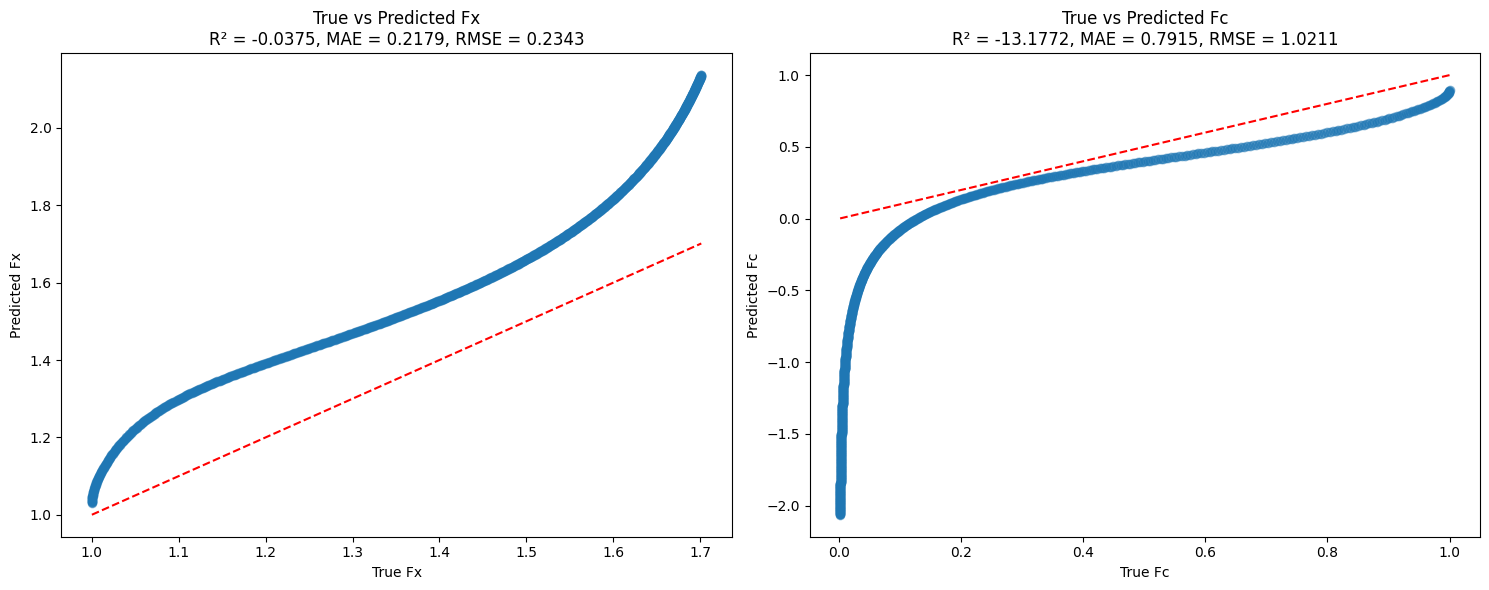

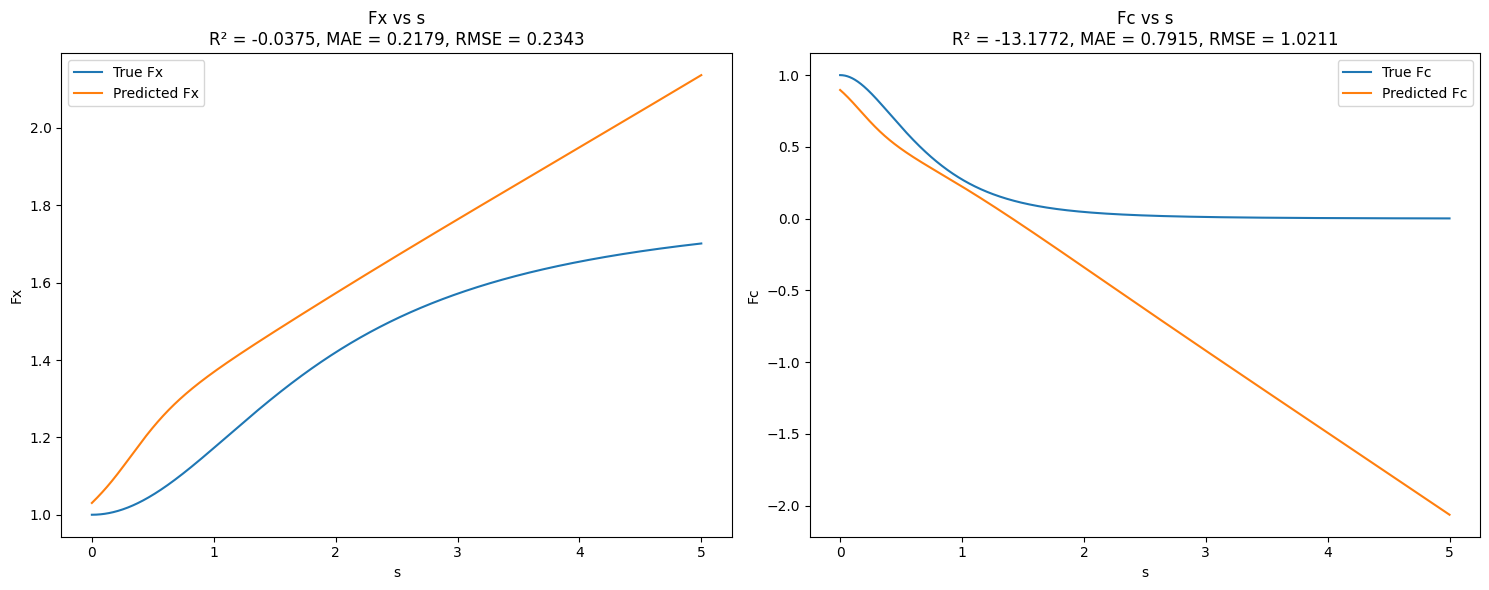

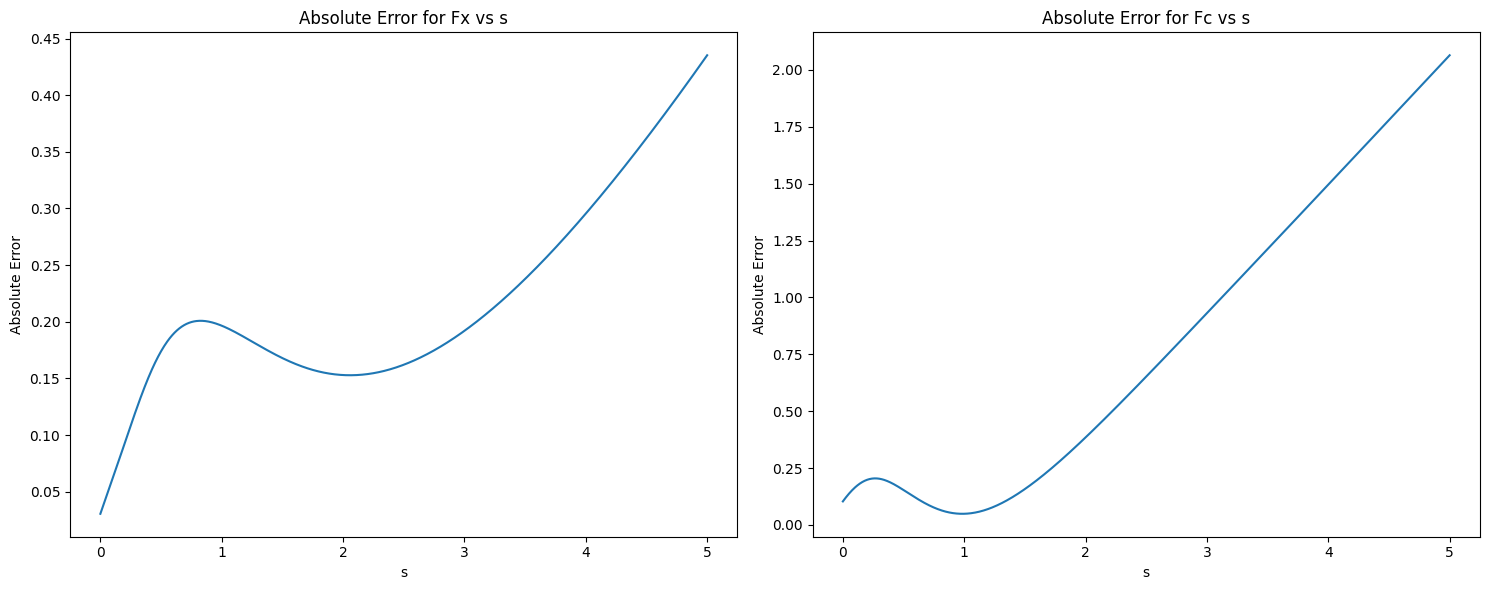

Fx Statistics:
R-squared: -0.037499
Mean Absolute Error: 0.217929
Root Mean Squared Error: 0.234301
Maximum Absolute Error: 0.435262

Fc Statistics:
R-squared: -13.177198
Mean Absolute Error: 0.791462
Root Mean Squared Error: 1.021133
Maximum Absolute Error: 2.064423


In [11]:
# Generate test points
test_s = jnp.linspace(START_S, STOP_S, num=1000)
test_rho = jnp.full_like(test_s, 1.0)  # We'll use a constant rho for simplicity

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
grad_rho_test = 2 * test_s * k_F_test * test_rho

# Prepare inputs for the neural networks
test_inputs = jnp.stack([test_rho, grad_rho_test], axis=1)
test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(test_rho, grad_rho_test)
true_fc_test = Fc(test_rho, grad_rho_test)

# Predict using neural networks
pred_fx_normalized = jax.vmap(model_fx)(test_inputs).squeeze()
pred_fx = pred_fx_normalized * true_fx_std + true_fx_mean
# # pred_fx = pred_fx_normalized

pred_fc_normalized = jax.vmap(model_fc)(test_inputs).squeeze()
pred_fc = pred_fc_normalized * true_fc_std + true_fc_mean
# pred_fc = pred_fc_normalized

# Function to calculate statistics
def calculate_stats(true, pred):
    # R-squared
    ss_res = np.sum((true - pred) ** 2)
    ss_tot = np.sum((true - np.mean(true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true - pred))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true - pred) ** 2))
    
    return r2, mae, rmse

# Calculate statistics
r2_fx, mae_fx, rmse_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc = calculate_stats(true_fc_test, pred_fc)

# 1. Correlation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(true_fx_test, pred_fx, alpha=0.5)
ax1.plot([true_fx_test.min(), true_fx_test.max()], [true_fx_test.min(), true_fx_test.max()], 'r--')
ax1.set_xlabel('True Fx')
ax1.set_ylabel('Predicted Fx')
ax1.set_title(f'True vs Predicted Fx\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')

ax2.scatter(true_fc_test, pred_fc, alpha=0.5)
ax2.plot([true_fc_test.min(), true_fc_test.max()], [true_fc_test.min(), true_fc_test.max()], 'r--')
ax2.set_xlabel('True Fc')
ax2.set_ylabel('Predicted Fc')
ax2.set_title(f'True vs Predicted Fc\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')

plt.tight_layout()
plt.show()

# 2. True PBE factors vs. s
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, true_fx_test, label='True Fx')
ax1.plot(test_s, pred_fx, label='Predicted Fx')
ax1.set_xlabel('s')
ax1.set_ylabel('Fx')
ax1.set_title(f'Fx vs s\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')
ax1.legend()

ax2.plot(test_s, true_fc_test, label='True Fc')
ax2.plot(test_s, pred_fc, label='Predicted Fc')
ax2.set_xlabel('s')
ax2.set_ylabel('Fc')
ax2.set_title(f'Fc vs s\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Error plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, np.abs(true_fx_test - pred_fx))
ax1.set_xlabel('s')
ax1.set_ylabel('Absolute Error')
ax1.set_title('Absolute Error for Fx vs s')

ax2.plot(test_s, np.abs(true_fc_test - pred_fc))
ax2.set_xlabel('s')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Absolute Error for Fc vs s')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fx_test - pred_fx)):.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fc_test - pred_fc)):.6f}")

# Including Constraints

There are various constraints which xc-diff and xcquinox are encoded to respect:
- Correct uniform density scaling behavior for $E_x$, which is enforced through dropping local-density inputs to the exchange enhancement factor (here, this means the `FxNet` should only depend on the gradient)
- At $s=0$, the UEG limit should be obtained. If the XC energy density is obtained through multiplying the enhancement factors by the UEG exchange/correlation energy densities, this means that $F_x(s=0)=1$ and $F_c(s=0)=1$.
- [Lieb-Oxford bound for the GGA enhancement factor](https://sci-hub.se/https://doi.org/10.1063/1.4870763) is $F_x^\mathrm{GGA}(s) < 1.804$; for the [MGGA enhancement factor](https://www.pnas.org/doi/epdf/10.1073/pnas.1423145112) is $F_x(s,\alpha) \leq F_x(s,\alpha=0) \leq 1.174$
- Correlation energy is non-positive, so the correlation enhancement factor must be non-negative: $F_c(s,\dots) \geq 0$.
- The exchange energy is negative, so the exchange enhancement factor must be postive: $F_x(s) \geq 0$.

The simplest way to enforce both the upper (Lieb-Oxford) and lower (positivity requirements) bounds are to pass the network outputs through a modified sigmoid function. xc-diff and xcquinox do this with the following modified sigmoid -- it enforces the domain to be within $[-1, a-1]$ via $$I_a(x) = \frac{a}{1+(a-1)\exp^{-x}} -1,\ \ I_a(0)=0,$$ and then adds one in the "definition" of the enhancement factor, i.e.: $$F_x(\tilde{x}_2,\tilde{x}_3) = 1 + I_{1.174}[(\tilde{x}_2+\tanh^2\tilde{x}_3)\mathcal{F}(\tilde{x}_2,\tilde{x}_3,\vec{\omega}_x)],$$ where the $(\tilde{x}_2+\tanh^2\tilde{x}_3)$ ensures the UEG limit is recovered for $s=x_2=\tilde{x}_2=0$ at $\alpha=x_3=1\to\tilde{x}_3=0$. $F_c$ is similarly constrained via $I_2(x)$, such that the end result lies in the range $[0, 1]$.

As a start, we'll omit the $\tanh^2$ term and just assume that $$F_x(s) = 1+I_{1.804}[s\cdot \mathcal{F}(s,\vec{\omega}_x)]$$ and $$F_c(\rho,s) = 1+I_2[s\cdot \mathcal{F}(\rho, s,\vec{\omega}_c)]$$

In [28]:
#Define the equinox module for the Lieb-Oxford bound enforcement
class LOB(eqx.Module):
    limit: float

    def __init__(self, limit: float):
        self.limit = limit

    def __call__(self, x):
        num = self.limit
        denom = 1+(self.limit-1)*jnp.exp(-x)
        return (num/denom) - 1

# Define the neural network module for Fx
class FxNet2(eqx.Module):
    depth: int
    nodes: int
    seed: int
    lob_lim: float
    net: eqx.nn.MLP
    lobf: eqx.Module

    def __init__(self, depth: int, nodes: int, seed: int, lob_lim=1.804):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.lob_lim = lob_lim
        #to constrain this, we require only gradient inputs
        self.net = eqx.nn.MLP(in_size = 1, # Input is ONLY grad_rho
                              out_size = 1, # Output is Fx
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))
        self.lobf = LOB(limit=lob_lim)

    

    def __call__(self, inputs):
        return 1+self.lobf((jnp.tanh(inputs)**2)*self.net(inputs).squeeze())

# Define the neural network module for Fc
class FcNet2(eqx.Module):
    depth: int
    nodes: int
    seed: int
    lob_lim: float
    net: eqx.nn.MLP
    lobf: eqx.Module


    def __init__(self, depth: int, nodes: int, seed: int, lob_lim=2.0):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.lob_lim = lob_lim
        self.net = eqx.nn.MLP(in_size = 2, # Input is rho, grad_rho
                              out_size = 1, # Output is Fx
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))
        self.lobf = LOB(limit=lob_lim)

    def __call__(self, inputs):
        return 1+self.lobf((jnp.tanh(inputs[1])**2)*self.net(inputs).squeeze())


In [ ]:
# Constants for generating grid points
START_RHO = 1e-8
STOP_RHO = 5.0
START_S = 0.0
STOP_S = 5.0
NPTS = 30000  # Note: Number of grid points [i.e. (x,y) pairs] is actually sqrt(NPTS).

# Generate training data
# Create more points for small values of s
s_values_low = jnp.linspace(START_S, 0.5, num=int(0.7 * jnp.sqrt(NPTS)))
s_values_high = jnp.linspace(0.5, STOP_S, num=int(0.3 * jnp.sqrt(NPTS)))
s_values = jnp.concatenate([s_values_low, s_values_high])

rho_values = jnp.logspace(jnp.log10(START_RHO), jnp.log10(STOP_RHO), num=int(jnp.sqrt(NPTS)))
#s_values = jnp.linspace(START_S, STOP_S, num=int(jnp.sqrt(NPTS))) #Use this for unbiased sampling

rho_mesh, s_mesh = jnp.meshgrid(rho_values, s_values)
rho_flat = rho_mesh.flatten()
s_flat = s_mesh.flatten()

# Calculate grad_rho
k_F = (3 * jnp.pi**2 * rho_flat)**(1/3)
grad_rho_flat = 2 * s_flat * k_F * rho_flat

# Create input array
inputs = jnp.stack([rho_flat, grad_rho_flat], axis=1)

# Calculate true Fx and Fc values
true_fx = Fx(rho_flat, grad_rho_flat)
true_fc = Fc(rho_flat, grad_rho_flat)

# Normalize inputs and outputs
inputs_mean = train_inputs.mean(axis=0)
inputs_std = train_inputs.std(axis=0)
inputs_normalized = (inputs - inputs_mean) / (inputs_std + 1e-8)

true_fx_mean = true_fx.mean()
true_fx_std = true_fx.std()
true_fx_normalized = (true_fx - true_fx_mean) / (true_fx_std + 1e-8)

true_fc_mean = true_fc.mean()
true_fc_std = true_fc.std()
true_fc_normalized = (true_fc - true_fc_mean) / (true_fc_std + 1e-8)

# Define the training loop function
def loop(model, model_name, inputs, ref, optimizer, epochs=1000000, printevery=2500): #model_name is just for printing purposes
    @eqx.filter_value_and_grad
    def compute_loss(model, inputs, ref):
        pred = jax.vmap(model)(inputs)
        loss = jnp.mean(jnp.abs(pred - ref))
        return loss

    @eqx.filter_jit
    def make_step(model, inputs, ref, opt_state):
        loss, grad = compute_loss(model, inputs, ref)
        updates, opt_state = optimizer.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
    print(f"Starting training for model: {model_name}")
    
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    losses = []

    for step in range(epochs):
        loss, model, opt_state = make_step(model, inputs, ref, opt_state)
        lossi = loss.item()
        losses.append(lossi)
        if step % printevery == 0:
            print(f'Epoch {step}: Loss = {lossi}')

    return model, losses

# Create optimizers
optimizer_fx = optax.chain(
    # optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=1e-4)
)
optimizer_fc = optax.chain(
    # optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=1e-4)
)

model_fx2 = FxNet2(depth=3, nodes=16, seed=42)
model_fc2 = FcNet2(depth=3, nodes=16, seed=42)

# Train the Fx model
# model_fx2, losses_fx = loop(model_fx2, 'Fx', inputs_normalized[:, 1][:, jnp.newaxis], true_fx_normalized, optimizer_fx, epochs=5000, printevery=1) #Can adjust number of epochs 
model_fx2, losses_fx = loop(model_fx2, 'Fx', inputs[:, 1][:, jnp.newaxis], true_fx, optimizer_fx, epochs=5000, printevery=100) #Can adjust number of epochs 

# Train the Fc model
# model_fc2, losses_fc = loop(model_fc2, 'Fc', inputs_normalized, true_fc_normalized, optimizer_fc, epochs=5000, printevery=100) #Can adjust number of epochs 
model_fc2, losses_fc = loop(model_fc2, 'Fc', inputs, true_fc, optimizer_fc, epochs=5000, printevery=100) #Can adjust number of epochs 


Starting training for model: Fx
Epoch 0: Loss = 0.16868051886558533
Epoch 100: Loss = 0.15356238186359406
Epoch 200: Loss = 0.15316437184810638


In [ ]:
# Generate test points
test_s = jnp.linspace(START_S, STOP_S, num=1000)
test_rho = jnp.full_like(test_s, 1.0)  # We'll use a constant rho for simplicity

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
grad_rho_test = 2 * test_s * k_F_test * test_rho

# Prepare inputs for the neural networks
test_inputs = jnp.stack([test_rho, grad_rho_test], axis=1)
test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(test_rho, grad_rho_test)
true_fc_test = Fc(test_rho, grad_rho_test)

# Predict using neural networks
pred_fx_normalized = jax.vmap(model_fx2)(test_inputs_normalized).squeeze()
pred_fx = pred_fx_normalized * true_fx_std + true_fx_mean

pred_fc_normalized = jax.vmap(model_fc2)(test_inputs_normalized).squeeze()
pred_fc = pred_fc_normalized * true_fc_std + true_fc_mean

# Function to calculate statistics
def calculate_stats(true, pred):
    # R-squared
    ss_res = np.sum((true - pred) ** 2)
    ss_tot = np.sum((true - np.mean(true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true - pred))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true - pred) ** 2))
    
    return r2, mae, rmse

# Calculate statistics
r2_fx, mae_fx, rmse_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc = calculate_stats(true_fc_test, pred_fc)

# 1. Correlation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(true_fx_test, pred_fx, alpha=0.5)
ax1.plot([true_fx_test.min(), true_fx_test.max()], [true_fx_test.min(), true_fx_test.max()], 'r--')
ax1.set_xlabel('True Fx')
ax1.set_ylabel('Predicted Fx')
ax1.set_title(f'True vs Predicted Fx\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')

ax2.scatter(true_fc_test, pred_fc, alpha=0.5)
ax2.plot([true_fc_test.min(), true_fc_test.max()], [true_fc_test.min(), true_fc_test.max()], 'r--')
ax2.set_xlabel('True Fc')
ax2.set_ylabel('Predicted Fc')
ax2.set_title(f'True vs Predicted Fc\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')

plt.tight_layout()
plt.show()

# 2. True PBE factors vs. s
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, true_fx_test, label='True Fx')
ax1.plot(test_s, pred_fx, label='Predicted Fx')
ax1.set_xlabel('s')
ax1.set_ylabel('Fx')
ax1.set_title(f'Fx vs s\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')
ax1.legend()

ax2.plot(test_s, true_fc_test, label='True Fc')
ax2.plot(test_s, pred_fc, label='Predicted Fc')
ax2.set_xlabel('s')
ax2.set_ylabel('Fc')
ax2.set_title(f'Fc vs s\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Error plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, np.abs(true_fx_test - pred_fx))
ax1.set_xlabel('s')
ax1.set_ylabel('Absolute Error')
ax1.set_title('Absolute Error for Fx vs s')

ax2.plot(test_s, np.abs(true_fc_test - pred_fc))
ax2.set_xlabel('s')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Absolute Error for Fc vs s')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fx_test - pred_fx)):.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fc_test - pred_fc)):.6f}")